## TensorFlow-Slim image classification model library

git clone https://github.com/tensorflow/models/

**TensorFlow-Slim**은 AlexNet, VGG, ResNet, Inception과 같이 image classification에 사용되는 Deep Learning CNN 모델을 제공하고 있다. CNN 모델 뿐만 아니라 여러 Datasets(ImageNet, CIFAR-10, MNIST 등)도 제공하고 있고 이를 이용한 학습 및 실험 코드도 제공하고 있다. 그리고 각 CNN 모델을 ImageNet 데이터로 학습한 Pre-trained 모델도 제공하여 새로운 Datasets에 대한 Fine-tuning도 가능하게 해준다.

In [1]:
%matplotlib inline

import os
import sys
import math
import numpy as np
import tensorflow as tf
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file

sys.path.insert(0,'../')
from utils import *
from cifar10_loader import CIFAR10_loader

sys.path.insert(0,'models/research/slim')
from nets import vgg

slim = tf.contrib.slim

### Download CIFAR-10 Dataset
**CIFAR-10** dataset은 32x32 사이즈의 이미지들로 airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck으로 이루어져있다. 각 클래스 별 6천장씩 구성되어 있으며 이중 50000장이 training에 사용되고 10000장이 test에 사용된다. TF-Slim library에서 제공하는 코드를 이용하여 현재 작업중인 폴더의 하위 폴더에 cifar-10 dataset을 저장한다.

*CIFAR datasets URL*: https://www.cs.toronto.edu/~kriz/cifar.html

*CIFAR-10 download link*: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [2]:
data_dir = '../cifar10_data'
data_url = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
maybe_download_and_extract(data_url, data_dir, 'cifar-10-batches')

loader = CIFAR10_loader()
class_names = loader.get_class_names()

Extracting Finished


/home/hanul/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


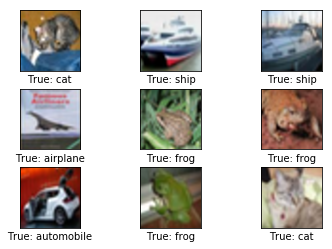

In [3]:
batch = loader.get_batch(9, (224,224))
fig = plot_images(batch['images'], batch['labels'], class_names)
fig.show()

# Parameters
VGG network는 입력 영상으로 224x224의 image를 받는다. 이번 실습에서는 **CIFAR-10**을 사용하므로 num_classes를 10으로 정의한다. 매 iteration 마다 100개의 images를 학습시키도록 batch_size를 100으로 한다. 총 epoch(학습 횟수)는 5회이고, 500번의 iteration마다 network의 parameters를 저장한다.

learning rate은 초기에 0.001로 정의하고 5 epochs마다 이 값은 1/10로 줄어든다. ImageNet으로 학습된 **VGG-16** network의 parameters는 **vgg_models/vgg_16.ckpt**이다.

#### Exercise 1-1
학습 횟수 50회, 초기 learning_rate 0.001, 매 10회 학습 마다 learning_rate은 20%로 감소

In [4]:
loader.reset() # set iterator as 0

image_size = 224 # input image size of VGG network
num_classes = 10 # CIFAR-10 number of classes
batch_size = 50 # number of images per training iteration

iteration_per_epoch = int(math.floor(loader.get_num_train_examples() / batch_size))
num_epochs = 30 # number of training epoch
save_checkpoint_frequency = 500 # frequency of saving checkpoints
print_frequency = 10

initial_learning_rate = 0.0001 # initial learning rate for optimizer
num_epochs_before_decay = 10
learning_rate_decay_rate = 0.5 # decay rate for learning rate

### Download pre-trained model (vgg-16)

https://github.com/tensorflow/models/tree/master/research/slim

TF-Slim github를 보면 ImageNet으로 학습된 Inception, Resnet, VGG 등 다양한 모델들의 checkpoints가 제공된다. 먼저 오늘 실습에 사용될 **VGG-16**의 checkpoint를 다운 받는다.

#### Exercise 1-2
vgg-19 network로 pre-trained model을 읽어와 학습할 수 있도록 수정

In [5]:
model_dir = 'vgg_models'
model_url = 'http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz'
maybe_download_and_extract(model_url, model_dir, 'vgg_16.ckpt')

checkpoint_path = 'vgg_models/vgg_16.ckpt' # Pre-trained VGG-16 checkpoints

print_tensors_in_checkpoint_file(file_name=checkpoint_path, tensor_name='', all_tensors=False)

vgg_16/fc8/weights (DT_FLOAT) [1,1,4096,1000]
vgg_16/fc7/weights (DT_FLOAT) [1,1,4096,4096]
vgg_16/fc7/biases (DT_FLOAT) [4096]
vgg_16/fc6/weights (DT_FLOAT) [7,7,512,4096]
vgg_16/fc8/biases (DT_FLOAT) [1000]
vgg_16/conv5/conv5_2/biases (DT_FLOAT) [512]
vgg_16/conv3/conv3_1/biases (DT_FLOAT) [256]
vgg_16/conv1/conv1_1/biases (DT_FLOAT) [64]
vgg_16/conv5/conv5_3/weights (DT_FLOAT) [3,3,512,512]
vgg_16/conv5/conv5_3/biases (DT_FLOAT) [512]
vgg_16/conv2/conv2_2/biases (DT_FLOAT) [128]
vgg_16/conv1/conv1_2/weights (DT_FLOAT) [3,3,64,64]
vgg_16/conv2/conv2_1/biases (DT_FLOAT) [128]
vgg_16/conv2/conv2_2/weights (DT_FLOAT) [3,3,128,128]
vgg_16/conv1/conv1_2/biases (DT_FLOAT) [64]
vgg_16/conv1/conv1_1/weights (DT_FLOAT) [3,3,3,64]
vgg_16/conv3/conv3_1/weights (DT_FLOAT) [3,3,128,256]
vgg_16/conv2/conv2_1/weights (DT_FLOAT) [3,3,64,128]
vgg_16/conv4/conv4_3/weights (DT_FLOAT) [3,3,512,512]
vgg_16/conv3/conv3_2/biases (DT_FLOAT) [256]
vgg_16/conv5/conv5_1/weights (DT_FLOAT) [3,3,512,512]
vgg_16/

### Create vgg-16 Model

https://github.com/tensorflow/models/blob/master/research/slim/nets/vgg.py

**VGG-16** network를 Slim library로 생성한다. 먼저 CNN에 입력으로 들어갈 영상, 클래스 레이블 2개의 placeholder를 정의하고, **CIFAR-10** dataset에 맞게 **VGG-16** 모델의 마지막 fc layer만 수정한다. **tf.contrib.slim.get_variables_to_restore()**을 통해 checkpoint로부터 가져 올 parameters를 정하도록 한다.

#### Exercise 1-2
vgg-19 network로 pre-trained model을 읽어와 학습할 수 있도록 수정

In [6]:
tf.reset_default_graph()

# input placeholders.
images = tf.placeholder(dtype=tf.float32, shape=[batch_size, image_size, image_size, 3],
                           name='images')
labels = tf.placeholder(dtype=tf.int64, shape=[batch_size], name='labels')

# Create the model, use the default arg scope to configure the batch norm parameters.
"""
activation_fn=tf.nn.relu,
weights_regularizer=slim.l2_regularizer(weight_decay),
biases_initializer=tf.zeros_initializer()
padding='SAME'
"""
with slim.arg_scope(vgg.vgg_arg_scope()):
    # 10 classes instead of 1001.
    logits, _ = vgg.vgg_16(images, num_classes=num_classes, is_training=True)
print(logits)

# Before defining remaining layers (softmax, optimizer), selecting the
# variables to be restored
exclude_layers = ['vgg_16/fc8']
#exclude_layers = ['vgg_16/fc8'] # when discaring only the last classification layer
variables_to_restore = slim.get_variables_to_restore(exclude=exclude_layers)
print('===> The list of variables to be restored:')
for i in variables_to_restore: print(i.op.name)

Tensor("vgg_16/fc8/squeezed:0", shape=(50, 10), dtype=float32)
===> The list of variables to be restored:
vgg_16/conv1/conv1_1/weights
vgg_16/conv1/conv1_1/biases
vgg_16/conv1/conv1_2/weights
vgg_16/conv1/conv1_2/biases
vgg_16/conv2/conv2_1/weights
vgg_16/conv2/conv2_1/biases
vgg_16/conv2/conv2_2/weights
vgg_16/conv2/conv2_2/biases
vgg_16/conv3/conv3_1/weights
vgg_16/conv3/conv3_1/biases
vgg_16/conv3/conv3_2/weights
vgg_16/conv3/conv3_2/biases
vgg_16/conv3/conv3_3/weights
vgg_16/conv3/conv3_3/biases
vgg_16/conv4/conv4_1/weights
vgg_16/conv4/conv4_1/biases
vgg_16/conv4/conv4_2/weights
vgg_16/conv4/conv4_2/biases
vgg_16/conv4/conv4_3/weights
vgg_16/conv4/conv4_3/biases
vgg_16/conv5/conv5_1/weights
vgg_16/conv5/conv5_1/biases
vgg_16/conv5/conv5_2/weights
vgg_16/conv5/conv5_2/biases
vgg_16/conv5/conv5_3/weights
vgg_16/conv5/conv5_3/biases
vgg_16/fc6/weights
vgg_16/fc6/biases
vgg_16/fc7/weights
vgg_16/fc7/biases


학습에 사용할 loss function과 optimizer를 정한다. 해당 실습에서는 cross_entropy와 softmax를 loss function으로 사용하였고, Gradient Descent알고리즘을 optimizer로 사용해 학습시켰다. **tf.contrib.slim.get_variables_to_restore()**을 통해 학습시킬 레이어를 선택할 수 있다.

#### Exercise 1-3
variable_to_learn을 이용하여 앞 단의 conv layer는 고정시키고 fc layers만 학습되도록 수정

참조: https://www.tensorflow.org/api_docs/python/tf/contrib/framework/get_variables_to_restore

In [7]:
# Define the loss function
probabilities = tf.nn.softmax(logits)
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=labels, logits=logits, name='cross_entropy_per_example')

print(probabilities)
print(loss)

# select variables to be learned
fix_layers = ['vgg_16/conv1', 'vgg_16/conv2', 'vgg_16/conv3', 'vgg_16/conv4', 'vgg_16/conv5']
variables_to_learn = slim.get_variables_to_restore(exclude=fix_layers)
#variables_to_learn = slim.get_variables_to_restore()

print('\n===> The list of variables to be learned:')
for i in variables_to_learn: print(i.op.name)

Tensor("Softmax:0", shape=(50, 10), dtype=float32)
Tensor("cross_entropy_per_example/cross_entropy_per_example:0", shape=(50,), dtype=float32)

===> The list of variables to be learned:
vgg_16/fc6/weights
vgg_16/fc6/biases
vgg_16/fc7/weights
vgg_16/fc7/biases
vgg_16/fc8/weights
vgg_16/fc8/biases


In [8]:
global_step = tf.Variable(0, trainable=False)
decay_step = int(num_epochs_before_decay * iteration_per_epoch)
    
lr = tf.train.exponential_decay(
    learning_rate = initial_learning_rate,
    global_step = global_step,
    decay_steps = decay_step,
    decay_rate = learning_rate_decay_rate,
    staircase = True)

# Specify the optimizer and create the train op:
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
#train_op = optimizer.minimize(loss, var_list=variables_to_learn, global_step=global_step) # train only target layers (ex: only fc layers)
train_op = optimizer.minimize(loss)

### Random initialization and Training from scratch : Fine-tuning VGG-16으로 넘어가서 진행
이부분은 수행하지 않고 넘어갑니다.
**VGG-16** network 모델의 parameters를 Random initialization한 후 **CIFAR-10** dataset으로 학습을 진행한다.

In [9]:
# Open the session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

conv1_1_weights = tf.get_default_graph().get_tensor_by_name('vgg_16/conv1/conv1_1/weights:0')
fc7_weights = tf.get_default_graph().get_tensor_by_name('vgg_16/fc7/weights:0')

rand_conv1_1 = conv1_1_weights[:,:,:,:].eval(session=sess)
rand_fc7 = fc7_weights[:,:,:,:].eval(session=sess)

print('Weight of conv1_1:')
print(rand_conv1_1[1,1,1,:10])
print('Weight of fc7:')
print(rand_fc7[0,0,0,:10])


Weight of conv1_1:
[-0.02137562 -0.09592298 -0.02027509  0.03651217  0.09572206  0.0848415
 -0.01229145 -0.00308987 -0.09702364 -0.09684193]
Weight of fc7:
[-0.01239542  0.00483879 -0.01823492  0.02333656 -0.01359449  0.02421528
 -0.02185658  0.02530734 -0.00185821 -0.01426812]


In [10]:
# Model parameters
save_path = 'cifar10_random-init_checkpoints/cifar10_cnn'
if not os.path.exists('cifar10_random-init_checkpoints'): 
    os.makedirs('cifar10_random-init_checkpoints')
    
# Train the model
saver = tf.train.Saver()
for ie in range(num_epochs):
    for ii in range(iteration_per_epoch):
        # Load a batch data
        batch = loader.get_batch(batch_size, 'train', (224,224))

        # Run the optimizer
        _ = sess.run([train_op], feed_dict={images:batch['images'],
                                            labels:batch['labels']})

        # Print the accuracy and loss of current batch data
        if (ii+1) % print_frequency == 0:
            batch_loss, batch_prob = sess.run([loss, probabilities], 
                                             feed_dict={images:batch['images'],
                                                        labels:batch['labels']})
            pred_labels = np.argmax(batch_prob, axis=1)
            batch_loss = np.mean(batch_loss)
            batch_acc = np.mean(np.equal(pred_labels, batch['labels']))
            print('%d Epoch %d iteration - Loss (%.3f) Accuracy (%.3f)'
                      %(ie+1, ii+1, batch_loss, batch_acc))

        # Save checkpoint
        if (ii+1) % save_checkpoint_frequency == 0:
            saver.save(sess, save_path=save_path, global_step=ie*iteration_per_epoch + ii + 1)
            print('Saved checkpoint %s_%d' % (save_path, ie*iteration_per_epoch + ii + 1))

sess.close()

1 Epoch 10 iteration - Loss (2.251) Accuracy (0.100)
1 Epoch 20 iteration - Loss (2.303) Accuracy (0.080)
1 Epoch 30 iteration - Loss (2.236) Accuracy (0.060)
1 Epoch 40 iteration - Loss (2.286) Accuracy (0.180)
1 Epoch 50 iteration - Loss (1.949) Accuracy (0.240)
1 Epoch 60 iteration - Loss (2.117) Accuracy (0.300)
1 Epoch 70 iteration - Loss (2.038) Accuracy (0.180)
1 Epoch 80 iteration - Loss (2.157) Accuracy (0.140)
1 Epoch 90 iteration - Loss (1.994) Accuracy (0.160)
1 Epoch 100 iteration - Loss (1.936) Accuracy (0.260)
1 Epoch 110 iteration - Loss (1.916) Accuracy (0.320)
1 Epoch 120 iteration - Loss (1.913) Accuracy (0.280)
1 Epoch 130 iteration - Loss (1.854) Accuracy (0.280)
1 Epoch 140 iteration - Loss (1.875) Accuracy (0.280)
1 Epoch 150 iteration - Loss (1.899) Accuracy (0.280)
1 Epoch 160 iteration - Loss (1.837) Accuracy (0.320)
1 Epoch 170 iteration - Loss (1.844) Accuracy (0.280)
1 Epoch 180 iteration - Loss (1.877) Accuracy (0.380)
1 Epoch 190 iteration - Loss (1.746) 

Saved checkpoint cifar10_ramdom-init_checkpoints/cifar10_cnn_1500
2 Epoch 510 iteration - Loss (0.878) Accuracy (0.740)
2 Epoch 520 iteration - Loss (0.742) Accuracy (0.740)
2 Epoch 530 iteration - Loss (0.535) Accuracy (0.800)
2 Epoch 540 iteration - Loss (0.735) Accuracy (0.700)
2 Epoch 550 iteration - Loss (0.645) Accuracy (0.800)
2 Epoch 560 iteration - Loss (0.637) Accuracy (0.840)
2 Epoch 570 iteration - Loss (0.704) Accuracy (0.800)
2 Epoch 580 iteration - Loss (0.496) Accuracy (0.860)
2 Epoch 590 iteration - Loss (0.791) Accuracy (0.700)
2 Epoch 600 iteration - Loss (0.388) Accuracy (0.820)
2 Epoch 610 iteration - Loss (0.729) Accuracy (0.680)
2 Epoch 620 iteration - Loss (0.739) Accuracy (0.760)
2 Epoch 630 iteration - Loss (0.613) Accuracy (0.720)
2 Epoch 640 iteration - Loss (0.609) Accuracy (0.800)
2 Epoch 650 iteration - Loss (0.759) Accuracy (0.780)
2 Epoch 660 iteration - Loss (0.708) Accuracy (0.720)
2 Epoch 670 iteration - Loss (0.689) Accuracy (0.760)
2 Epoch 680 iter

3 Epoch 1000 iteration - Loss (0.352) Accuracy (0.860)
Saved checkpoint cifar10_ramdom-init_checkpoints/cifar10_cnn_3000
4 Epoch 10 iteration - Loss (0.214) Accuracy (0.920)
4 Epoch 20 iteration - Loss (0.424) Accuracy (0.880)
4 Epoch 30 iteration - Loss (0.478) Accuracy (0.800)
4 Epoch 40 iteration - Loss (0.275) Accuracy (0.940)
4 Epoch 50 iteration - Loss (0.054) Accuracy (1.000)
4 Epoch 60 iteration - Loss (0.444) Accuracy (0.800)
4 Epoch 70 iteration - Loss (0.342) Accuracy (0.880)
4 Epoch 80 iteration - Loss (0.258) Accuracy (0.920)
4 Epoch 90 iteration - Loss (0.505) Accuracy (0.860)
4 Epoch 100 iteration - Loss (0.488) Accuracy (0.800)
4 Epoch 110 iteration - Loss (0.378) Accuracy (0.860)
4 Epoch 120 iteration - Loss (0.222) Accuracy (0.940)
4 Epoch 130 iteration - Loss (0.243) Accuracy (0.920)
4 Epoch 140 iteration - Loss (0.272) Accuracy (0.880)
4 Epoch 150 iteration - Loss (0.337) Accuracy (0.880)
4 Epoch 160 iteration - Loss (0.383) Accuracy (0.900)
4 Epoch 170 iteration - 

5 Epoch 490 iteration - Loss (0.092) Accuracy (1.000)
5 Epoch 500 iteration - Loss (0.128) Accuracy (0.960)
Saved checkpoint cifar10_ramdom-init_checkpoints/cifar10_cnn_4500
5 Epoch 510 iteration - Loss (0.147) Accuracy (0.960)
5 Epoch 520 iteration - Loss (0.149) Accuracy (0.960)
5 Epoch 530 iteration - Loss (0.168) Accuracy (0.980)
5 Epoch 540 iteration - Loss (0.235) Accuracy (0.920)
5 Epoch 550 iteration - Loss (0.147) Accuracy (0.960)
5 Epoch 560 iteration - Loss (0.109) Accuracy (0.980)
5 Epoch 570 iteration - Loss (0.119) Accuracy (0.960)
5 Epoch 580 iteration - Loss (0.107) Accuracy (0.960)
5 Epoch 590 iteration - Loss (0.147) Accuracy (0.960)
5 Epoch 600 iteration - Loss (0.027) Accuracy (1.000)
5 Epoch 610 iteration - Loss (0.055) Accuracy (0.980)
5 Epoch 620 iteration - Loss (0.123) Accuracy (0.980)
5 Epoch 630 iteration - Loss (0.079) Accuracy (0.980)
5 Epoch 640 iteration - Loss (0.061) Accuracy (0.960)
5 Epoch 650 iteration - Loss (0.091) Accuracy (0.960)
5 Epoch 660 iter

6 Epoch 980 iteration - Loss (0.053) Accuracy (0.980)
6 Epoch 990 iteration - Loss (0.026) Accuracy (1.000)
6 Epoch 1000 iteration - Loss (0.085) Accuracy (0.960)
Saved checkpoint cifar10_ramdom-init_checkpoints/cifar10_cnn_6000
7 Epoch 10 iteration - Loss (0.053) Accuracy (1.000)
7 Epoch 20 iteration - Loss (0.009) Accuracy (1.000)
7 Epoch 30 iteration - Loss (0.051) Accuracy (0.980)
7 Epoch 40 iteration - Loss (0.074) Accuracy (0.980)
7 Epoch 50 iteration - Loss (0.098) Accuracy (0.960)
7 Epoch 60 iteration - Loss (0.129) Accuracy (0.960)
7 Epoch 70 iteration - Loss (0.060) Accuracy (0.980)
7 Epoch 80 iteration - Loss (0.020) Accuracy (1.000)
7 Epoch 90 iteration - Loss (0.056) Accuracy (0.980)
7 Epoch 100 iteration - Loss (0.136) Accuracy (0.940)
7 Epoch 110 iteration - Loss (0.020) Accuracy (1.000)
7 Epoch 120 iteration - Loss (0.008) Accuracy (1.000)
7 Epoch 130 iteration - Loss (0.021) Accuracy (1.000)
7 Epoch 140 iteration - Loss (0.018) Accuracy (1.000)
7 Epoch 150 iteration - 

8 Epoch 470 iteration - Loss (0.108) Accuracy (0.960)
8 Epoch 480 iteration - Loss (0.032) Accuracy (0.980)
8 Epoch 490 iteration - Loss (0.009) Accuracy (1.000)
8 Epoch 500 iteration - Loss (0.073) Accuracy (0.980)
Saved checkpoint cifar10_ramdom-init_checkpoints/cifar10_cnn_7500
8 Epoch 510 iteration - Loss (0.079) Accuracy (0.980)
8 Epoch 520 iteration - Loss (0.032) Accuracy (0.980)
8 Epoch 530 iteration - Loss (0.070) Accuracy (0.980)
8 Epoch 540 iteration - Loss (0.030) Accuracy (0.980)
8 Epoch 550 iteration - Loss (0.051) Accuracy (0.980)
8 Epoch 560 iteration - Loss (0.047) Accuracy (1.000)
8 Epoch 570 iteration - Loss (0.043) Accuracy (1.000)
8 Epoch 580 iteration - Loss (0.063) Accuracy (0.960)
8 Epoch 590 iteration - Loss (0.018) Accuracy (1.000)
8 Epoch 600 iteration - Loss (0.012) Accuracy (1.000)
8 Epoch 610 iteration - Loss (0.016) Accuracy (1.000)
8 Epoch 620 iteration - Loss (0.019) Accuracy (1.000)
8 Epoch 630 iteration - Loss (0.021) Accuracy (1.000)
8 Epoch 640 iter

9 Epoch 960 iteration - Loss (0.062) Accuracy (0.960)
9 Epoch 970 iteration - Loss (0.129) Accuracy (0.960)
9 Epoch 980 iteration - Loss (0.061) Accuracy (0.980)
9 Epoch 990 iteration - Loss (0.029) Accuracy (1.000)
9 Epoch 1000 iteration - Loss (0.017) Accuracy (1.000)
Saved checkpoint cifar10_ramdom-init_checkpoints/cifar10_cnn_9000
10 Epoch 10 iteration - Loss (0.030) Accuracy (0.980)
10 Epoch 20 iteration - Loss (0.004) Accuracy (1.000)
10 Epoch 30 iteration - Loss (0.009) Accuracy (1.000)
10 Epoch 40 iteration - Loss (0.079) Accuracy (0.980)
10 Epoch 50 iteration - Loss (0.010) Accuracy (1.000)
10 Epoch 60 iteration - Loss (0.021) Accuracy (1.000)
10 Epoch 70 iteration - Loss (0.063) Accuracy (0.980)
10 Epoch 80 iteration - Loss (0.041) Accuracy (0.980)
10 Epoch 90 iteration - Loss (0.016) Accuracy (1.000)
10 Epoch 100 iteration - Loss (0.011) Accuracy (1.000)
10 Epoch 110 iteration - Loss (0.129) Accuracy (0.960)
10 Epoch 120 iteration - Loss (0.034) Accuracy (0.980)
10 Epoch 130

11 Epoch 420 iteration - Loss (0.020) Accuracy (1.000)
11 Epoch 430 iteration - Loss (0.037) Accuracy (0.980)
11 Epoch 440 iteration - Loss (0.026) Accuracy (1.000)
11 Epoch 450 iteration - Loss (0.015) Accuracy (1.000)
11 Epoch 460 iteration - Loss (0.002) Accuracy (1.000)
11 Epoch 470 iteration - Loss (0.004) Accuracy (1.000)
11 Epoch 480 iteration - Loss (0.046) Accuracy (0.980)
11 Epoch 490 iteration - Loss (0.008) Accuracy (1.000)
11 Epoch 500 iteration - Loss (0.003) Accuracy (1.000)
Saved checkpoint cifar10_ramdom-init_checkpoints/cifar10_cnn_10500
11 Epoch 510 iteration - Loss (0.005) Accuracy (1.000)
11 Epoch 520 iteration - Loss (0.075) Accuracy (0.980)
11 Epoch 530 iteration - Loss (0.001) Accuracy (1.000)
11 Epoch 540 iteration - Loss (0.006) Accuracy (1.000)
11 Epoch 550 iteration - Loss (0.008) Accuracy (1.000)
11 Epoch 560 iteration - Loss (0.007) Accuracy (1.000)
11 Epoch 570 iteration - Loss (0.012) Accuracy (1.000)
11 Epoch 580 iteration - Loss (0.016) Accuracy (1.000

12 Epoch 880 iteration - Loss (0.003) Accuracy (1.000)
12 Epoch 890 iteration - Loss (0.015) Accuracy (1.000)
12 Epoch 900 iteration - Loss (0.020) Accuracy (1.000)
12 Epoch 910 iteration - Loss (0.006) Accuracy (1.000)
12 Epoch 920 iteration - Loss (0.013) Accuracy (1.000)
12 Epoch 930 iteration - Loss (0.003) Accuracy (1.000)
12 Epoch 940 iteration - Loss (0.009) Accuracy (1.000)
12 Epoch 950 iteration - Loss (0.020) Accuracy (1.000)
12 Epoch 960 iteration - Loss (0.009) Accuracy (1.000)
12 Epoch 970 iteration - Loss (0.017) Accuracy (1.000)
12 Epoch 980 iteration - Loss (0.010) Accuracy (1.000)
12 Epoch 990 iteration - Loss (0.004) Accuracy (1.000)
12 Epoch 1000 iteration - Loss (0.094) Accuracy (0.960)
Saved checkpoint cifar10_ramdom-init_checkpoints/cifar10_cnn_12000
13 Epoch 10 iteration - Loss (0.010) Accuracy (1.000)
13 Epoch 20 iteration - Loss (0.022) Accuracy (0.980)
13 Epoch 30 iteration - Loss (0.002) Accuracy (1.000)
13 Epoch 40 iteration - Loss (0.019) Accuracy (1.000)
1

14 Epoch 340 iteration - Loss (0.016) Accuracy (1.000)
14 Epoch 350 iteration - Loss (0.020) Accuracy (1.000)
14 Epoch 360 iteration - Loss (0.032) Accuracy (0.980)
14 Epoch 370 iteration - Loss (0.014) Accuracy (1.000)
14 Epoch 380 iteration - Loss (0.012) Accuracy (1.000)
14 Epoch 390 iteration - Loss (0.016) Accuracy (0.980)
14 Epoch 400 iteration - Loss (0.031) Accuracy (1.000)
14 Epoch 410 iteration - Loss (0.003) Accuracy (1.000)
14 Epoch 420 iteration - Loss (0.012) Accuracy (1.000)
14 Epoch 430 iteration - Loss (0.008) Accuracy (1.000)
14 Epoch 440 iteration - Loss (0.017) Accuracy (1.000)
14 Epoch 450 iteration - Loss (0.004) Accuracy (1.000)
14 Epoch 460 iteration - Loss (0.020) Accuracy (1.000)
14 Epoch 470 iteration - Loss (0.019) Accuracy (1.000)
14 Epoch 480 iteration - Loss (0.178) Accuracy (0.980)
14 Epoch 490 iteration - Loss (0.017) Accuracy (1.000)
14 Epoch 500 iteration - Loss (0.013) Accuracy (1.000)
Saved checkpoint cifar10_ramdom-init_checkpoints/cifar10_cnn_1350

15 Epoch 800 iteration - Loss (0.022) Accuracy (0.980)
15 Epoch 810 iteration - Loss (0.007) Accuracy (1.000)
15 Epoch 820 iteration - Loss (0.003) Accuracy (1.000)
15 Epoch 830 iteration - Loss (0.030) Accuracy (1.000)
15 Epoch 840 iteration - Loss (0.001) Accuracy (1.000)
15 Epoch 850 iteration - Loss (0.008) Accuracy (1.000)
15 Epoch 860 iteration - Loss (0.004) Accuracy (1.000)
15 Epoch 870 iteration - Loss (0.006) Accuracy (1.000)
15 Epoch 880 iteration - Loss (0.001) Accuracy (1.000)
15 Epoch 890 iteration - Loss (0.013) Accuracy (1.000)
15 Epoch 900 iteration - Loss (0.006) Accuracy (1.000)
15 Epoch 910 iteration - Loss (0.007) Accuracy (1.000)
15 Epoch 920 iteration - Loss (0.001) Accuracy (1.000)
15 Epoch 930 iteration - Loss (0.074) Accuracy (0.980)
15 Epoch 940 iteration - Loss (0.015) Accuracy (1.000)
15 Epoch 950 iteration - Loss (0.034) Accuracy (0.980)
15 Epoch 960 iteration - Loss (0.105) Accuracy (0.980)
15 Epoch 970 iteration - Loss (0.046) Accuracy (0.980)
15 Epoch 9

17 Epoch 260 iteration - Loss (0.001) Accuracy (1.000)
17 Epoch 270 iteration - Loss (0.006) Accuracy (1.000)
17 Epoch 280 iteration - Loss (0.007) Accuracy (1.000)
17 Epoch 290 iteration - Loss (0.018) Accuracy (1.000)
17 Epoch 300 iteration - Loss (0.007) Accuracy (1.000)
17 Epoch 310 iteration - Loss (0.010) Accuracy (1.000)
17 Epoch 320 iteration - Loss (0.012) Accuracy (1.000)
17 Epoch 330 iteration - Loss (0.005) Accuracy (1.000)
17 Epoch 340 iteration - Loss (0.004) Accuracy (1.000)
17 Epoch 350 iteration - Loss (0.003) Accuracy (1.000)
17 Epoch 360 iteration - Loss (0.003) Accuracy (1.000)
17 Epoch 370 iteration - Loss (0.003) Accuracy (1.000)
17 Epoch 380 iteration - Loss (0.025) Accuracy (0.980)
17 Epoch 390 iteration - Loss (0.049) Accuracy (0.980)
17 Epoch 400 iteration - Loss (0.047) Accuracy (0.980)
17 Epoch 410 iteration - Loss (0.013) Accuracy (1.000)
17 Epoch 420 iteration - Loss (0.014) Accuracy (1.000)
17 Epoch 430 iteration - Loss (0.027) Accuracy (1.000)
17 Epoch 4

18 Epoch 720 iteration - Loss (0.013) Accuracy (1.000)
18 Epoch 730 iteration - Loss (0.005) Accuracy (1.000)
18 Epoch 740 iteration - Loss (0.003) Accuracy (1.000)
18 Epoch 750 iteration - Loss (0.013) Accuracy (1.000)
18 Epoch 760 iteration - Loss (0.018) Accuracy (1.000)
18 Epoch 770 iteration - Loss (0.012) Accuracy (1.000)
18 Epoch 780 iteration - Loss (0.004) Accuracy (1.000)
18 Epoch 790 iteration - Loss (0.003) Accuracy (1.000)
18 Epoch 800 iteration - Loss (0.028) Accuracy (0.980)
18 Epoch 810 iteration - Loss (0.014) Accuracy (1.000)
18 Epoch 820 iteration - Loss (0.001) Accuracy (1.000)
18 Epoch 830 iteration - Loss (0.067) Accuracy (0.980)
18 Epoch 840 iteration - Loss (0.015) Accuracy (1.000)
18 Epoch 850 iteration - Loss (0.051) Accuracy (0.980)
18 Epoch 860 iteration - Loss (0.012) Accuracy (1.000)
18 Epoch 870 iteration - Loss (0.015) Accuracy (1.000)
18 Epoch 880 iteration - Loss (0.031) Accuracy (1.000)
18 Epoch 890 iteration - Loss (0.007) Accuracy (1.000)
18 Epoch 9

20 Epoch 180 iteration - Loss (0.017) Accuracy (1.000)
20 Epoch 190 iteration - Loss (0.009) Accuracy (1.000)
20 Epoch 200 iteration - Loss (0.018) Accuracy (1.000)
20 Epoch 210 iteration - Loss (0.010) Accuracy (1.000)
20 Epoch 220 iteration - Loss (0.001) Accuracy (1.000)
20 Epoch 230 iteration - Loss (0.007) Accuracy (1.000)
20 Epoch 240 iteration - Loss (0.007) Accuracy (1.000)
20 Epoch 250 iteration - Loss (0.023) Accuracy (0.980)
20 Epoch 260 iteration - Loss (0.037) Accuracy (0.980)
20 Epoch 270 iteration - Loss (0.147) Accuracy (0.980)
20 Epoch 280 iteration - Loss (0.006) Accuracy (1.000)
20 Epoch 290 iteration - Loss (0.003) Accuracy (1.000)
20 Epoch 300 iteration - Loss (0.014) Accuracy (1.000)
20 Epoch 310 iteration - Loss (0.015) Accuracy (1.000)
20 Epoch 320 iteration - Loss (0.008) Accuracy (1.000)
20 Epoch 330 iteration - Loss (0.001) Accuracy (1.000)
20 Epoch 340 iteration - Loss (0.009) Accuracy (1.000)
20 Epoch 350 iteration - Loss (0.088) Accuracy (0.980)
20 Epoch 3

21 Epoch 640 iteration - Loss (0.008) Accuracy (1.000)
21 Epoch 650 iteration - Loss (0.014) Accuracy (1.000)
21 Epoch 660 iteration - Loss (0.002) Accuracy (1.000)
21 Epoch 670 iteration - Loss (0.046) Accuracy (0.980)
21 Epoch 680 iteration - Loss (0.005) Accuracy (1.000)
21 Epoch 690 iteration - Loss (0.002) Accuracy (1.000)
21 Epoch 700 iteration - Loss (0.003) Accuracy (1.000)
21 Epoch 710 iteration - Loss (0.001) Accuracy (1.000)
21 Epoch 720 iteration - Loss (0.005) Accuracy (1.000)
21 Epoch 730 iteration - Loss (0.001) Accuracy (1.000)
21 Epoch 740 iteration - Loss (0.014) Accuracy (1.000)
21 Epoch 750 iteration - Loss (0.001) Accuracy (1.000)
21 Epoch 760 iteration - Loss (0.002) Accuracy (1.000)
21 Epoch 770 iteration - Loss (0.017) Accuracy (1.000)
21 Epoch 780 iteration - Loss (0.002) Accuracy (1.000)
21 Epoch 790 iteration - Loss (0.001) Accuracy (1.000)
21 Epoch 800 iteration - Loss (0.007) Accuracy (1.000)
21 Epoch 810 iteration - Loss (0.001) Accuracy (1.000)
21 Epoch 8

23 Epoch 100 iteration - Loss (0.006) Accuracy (1.000)
23 Epoch 110 iteration - Loss (0.006) Accuracy (1.000)
23 Epoch 120 iteration - Loss (0.004) Accuracy (1.000)
23 Epoch 130 iteration - Loss (0.029) Accuracy (1.000)
23 Epoch 140 iteration - Loss (0.000) Accuracy (1.000)
23 Epoch 150 iteration - Loss (0.002) Accuracy (1.000)
23 Epoch 160 iteration - Loss (0.011) Accuracy (1.000)
23 Epoch 170 iteration - Loss (0.006) Accuracy (1.000)
23 Epoch 180 iteration - Loss (0.000) Accuracy (1.000)
23 Epoch 190 iteration - Loss (0.001) Accuracy (1.000)
23 Epoch 200 iteration - Loss (0.000) Accuracy (1.000)
23 Epoch 210 iteration - Loss (0.004) Accuracy (1.000)
23 Epoch 220 iteration - Loss (0.037) Accuracy (0.980)
23 Epoch 230 iteration - Loss (0.002) Accuracy (1.000)
23 Epoch 240 iteration - Loss (0.011) Accuracy (1.000)
23 Epoch 250 iteration - Loss (0.015) Accuracy (1.000)
23 Epoch 260 iteration - Loss (0.063) Accuracy (0.980)
23 Epoch 270 iteration - Loss (0.012) Accuracy (1.000)
23 Epoch 2

24 Epoch 560 iteration - Loss (0.000) Accuracy (1.000)
24 Epoch 570 iteration - Loss (0.008) Accuracy (1.000)
24 Epoch 580 iteration - Loss (0.007) Accuracy (1.000)
24 Epoch 590 iteration - Loss (0.001) Accuracy (1.000)
24 Epoch 600 iteration - Loss (0.000) Accuracy (1.000)
24 Epoch 610 iteration - Loss (0.002) Accuracy (1.000)
24 Epoch 620 iteration - Loss (0.002) Accuracy (1.000)
24 Epoch 630 iteration - Loss (0.003) Accuracy (1.000)
24 Epoch 640 iteration - Loss (0.053) Accuracy (0.980)
24 Epoch 650 iteration - Loss (0.002) Accuracy (1.000)
24 Epoch 660 iteration - Loss (0.036) Accuracy (0.980)
24 Epoch 670 iteration - Loss (0.000) Accuracy (1.000)
24 Epoch 680 iteration - Loss (0.001) Accuracy (1.000)
24 Epoch 690 iteration - Loss (0.009) Accuracy (1.000)
24 Epoch 700 iteration - Loss (0.004) Accuracy (1.000)
24 Epoch 710 iteration - Loss (0.001) Accuracy (1.000)
24 Epoch 720 iteration - Loss (0.001) Accuracy (1.000)
24 Epoch 730 iteration - Loss (0.011) Accuracy (1.000)
24 Epoch 7

26 Epoch 20 iteration - Loss (0.000) Accuracy (1.000)
26 Epoch 30 iteration - Loss (0.003) Accuracy (1.000)
26 Epoch 40 iteration - Loss (0.003) Accuracy (1.000)
26 Epoch 50 iteration - Loss (0.001) Accuracy (1.000)
26 Epoch 60 iteration - Loss (0.022) Accuracy (0.980)
26 Epoch 70 iteration - Loss (0.010) Accuracy (1.000)
26 Epoch 80 iteration - Loss (0.003) Accuracy (1.000)
26 Epoch 90 iteration - Loss (0.002) Accuracy (1.000)
26 Epoch 100 iteration - Loss (0.032) Accuracy (0.980)
26 Epoch 110 iteration - Loss (0.005) Accuracy (1.000)
26 Epoch 120 iteration - Loss (0.002) Accuracy (1.000)
26 Epoch 130 iteration - Loss (0.005) Accuracy (1.000)
26 Epoch 140 iteration - Loss (0.000) Accuracy (1.000)
26 Epoch 150 iteration - Loss (0.000) Accuracy (1.000)
26 Epoch 160 iteration - Loss (0.000) Accuracy (1.000)
26 Epoch 170 iteration - Loss (0.003) Accuracy (1.000)
26 Epoch 180 iteration - Loss (0.000) Accuracy (1.000)
26 Epoch 190 iteration - Loss (0.014) Accuracy (1.000)
26 Epoch 200 itera

27 Epoch 490 iteration - Loss (0.001) Accuracy (1.000)
27 Epoch 500 iteration - Loss (0.002) Accuracy (1.000)
Saved checkpoint cifar10_ramdom-init_checkpoints/cifar10_cnn_26500
27 Epoch 510 iteration - Loss (0.005) Accuracy (1.000)
27 Epoch 520 iteration - Loss (0.005) Accuracy (1.000)
27 Epoch 530 iteration - Loss (0.010) Accuracy (1.000)
27 Epoch 540 iteration - Loss (0.002) Accuracy (1.000)
27 Epoch 550 iteration - Loss (0.004) Accuracy (1.000)
27 Epoch 560 iteration - Loss (0.004) Accuracy (1.000)
27 Epoch 570 iteration - Loss (0.003) Accuracy (1.000)
27 Epoch 580 iteration - Loss (0.016) Accuracy (1.000)
27 Epoch 590 iteration - Loss (0.000) Accuracy (1.000)
27 Epoch 600 iteration - Loss (0.001) Accuracy (1.000)
27 Epoch 610 iteration - Loss (0.026) Accuracy (0.980)
27 Epoch 620 iteration - Loss (0.001) Accuracy (1.000)
27 Epoch 630 iteration - Loss (0.003) Accuracy (1.000)
27 Epoch 640 iteration - Loss (0.006) Accuracy (1.000)
27 Epoch 650 iteration - Loss (0.011) Accuracy (1.000

28 Epoch 950 iteration - Loss (0.004) Accuracy (1.000)
28 Epoch 960 iteration - Loss (0.003) Accuracy (1.000)
28 Epoch 970 iteration - Loss (0.079) Accuracy (0.980)
28 Epoch 980 iteration - Loss (0.034) Accuracy (0.980)
28 Epoch 990 iteration - Loss (0.002) Accuracy (1.000)
28 Epoch 1000 iteration - Loss (0.049) Accuracy (0.980)
Saved checkpoint cifar10_ramdom-init_checkpoints/cifar10_cnn_28000
29 Epoch 10 iteration - Loss (0.004) Accuracy (1.000)
29 Epoch 20 iteration - Loss (0.003) Accuracy (1.000)
29 Epoch 30 iteration - Loss (0.005) Accuracy (1.000)
29 Epoch 40 iteration - Loss (0.007) Accuracy (1.000)
29 Epoch 50 iteration - Loss (0.000) Accuracy (1.000)
29 Epoch 60 iteration - Loss (0.002) Accuracy (1.000)
29 Epoch 70 iteration - Loss (0.000) Accuracy (1.000)
29 Epoch 80 iteration - Loss (0.000) Accuracy (1.000)
29 Epoch 90 iteration - Loss (0.001) Accuracy (1.000)
29 Epoch 100 iteration - Loss (0.015) Accuracy (1.000)
29 Epoch 110 iteration - Loss (0.000) Accuracy (1.000)
29 Epo

30 Epoch 410 iteration - Loss (0.001) Accuracy (1.000)
30 Epoch 420 iteration - Loss (0.008) Accuracy (1.000)
30 Epoch 430 iteration - Loss (0.002) Accuracy (1.000)
30 Epoch 440 iteration - Loss (0.007) Accuracy (1.000)
30 Epoch 450 iteration - Loss (0.000) Accuracy (1.000)
30 Epoch 460 iteration - Loss (0.001) Accuracy (1.000)
30 Epoch 470 iteration - Loss (0.001) Accuracy (1.000)
30 Epoch 480 iteration - Loss (0.006) Accuracy (1.000)
30 Epoch 490 iteration - Loss (0.001) Accuracy (1.000)
30 Epoch 500 iteration - Loss (0.012) Accuracy (1.000)
Saved checkpoint cifar10_ramdom-init_checkpoints/cifar10_cnn_29500
30 Epoch 510 iteration - Loss (0.000) Accuracy (1.000)
30 Epoch 520 iteration - Loss (0.001) Accuracy (1.000)
30 Epoch 530 iteration - Loss (0.003) Accuracy (1.000)
30 Epoch 540 iteration - Loss (0.000) Accuracy (1.000)
30 Epoch 550 iteration - Loss (0.043) Accuracy (0.980)
30 Epoch 560 iteration - Loss (0.000) Accuracy (1.000)
30 Epoch 570 iteration - Loss (0.001) Accuracy (1.000

### Evaluate Model

In [13]:
iteration_per_epoch = int(math.floor(loader.get_num_test_examples() / batch_size))
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir='cifar10_random-init_checkpoints/')
print('Last checkpoint path is %s' % (checkpoint_path))

print(iteration_per_epoch)

# Open the session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()

# Load the checkpoint or initialize the variables
saver.restore(sess, save_path=checkpoint_path)
print('Model is restored from %s' % checkpoint_path)

loader.reset()
num_correct = 0
num_examples = 0
ii = 0

# Evaluate the model
while True:
    # Load a batch data
    batch = loader.get_batch(batch_size, 'test', (224,224))
    if batch['wrapped']: break

    # Compute the correct numbers
    batch_prob = sess.run(probabilities, feed_dict={images:batch['images'],
                                                      labels:batch['labels']})

    pred_labels = np.argmax(batch_prob, axis=1)
    batch_correct_num = np.sum(np.equal(pred_labels, batch['labels']))

    num_correct += batch_correct_num
    num_examples += batch_size
    
    if (ii+1) % 10 == 0:
        print('%d/%d done' % (ii+1, iteration_per_epoch))
    ii += 1
print('Test accuracy: %.2f%%' % (float(num_correct) / float(num_examples) * 100.0))

sess.close()

Last checkpoint path is cifar10_random-init_checkpoints/cifar10_cnn-30000
200
INFO:tensorflow:Restoring parameters from cifar10_random-init_checkpoints/cifar10_cnn-30000
Model is restored from cifar10_random-init_checkpoints/cifar10_cnn-30000
10/200 done
20/200 done
30/200 done
40/200 done
50/200 done
60/200 done
70/200 done
80/200 done
90/200 done
100/200 done
110/200 done
120/200 done
130/200 done
140/200 done
150/200 done
160/200 done
170/200 done
180/200 done
190/200 done
200/200 done
Test accuracy: 79.93%


### Fine-tuning VGG-16
**vgg_models/vgg_16.ckpt** 파일을 읽어와 위에서 정의한 **VGG-16** network의 parameters을 수정한 후 **CIFAR-10** dataset을 학습시킨다.

In [ ]:
# Create the saver with variables to be restored
restorer = tf.train.Saver(variables_to_restore)

# Open the session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

checkpoint_path='vgg_models/vgg_16.ckpt'
restorer.restore(sess, save_path=checkpoint_path)
    
print('Model is restored from %s' % checkpoint_path)

save_path = 'cifar10_fine-tuning_checkpoints/cifar10_cnn'
if not os.path.exists('cifar10_fine-tuning_checkpoints'): 
    os.makedirs('cifar10_fine-tuning_checkpoints')

# Train the model
saver = tf.train.Saver()
for ie in range(num_epochs):
    for ii in range(iteration_per_epoch):
        # Load a batch data
        batch = loader.get_batch(batch_size, 'train', (224,224))
        
        # Run the optimizer
        _ = sess.run([train_op], feed_dict={images:batch['images'],
                                            labels:batch['labels']})
        '''
        if (num_epochs < 10):
            _ = sess.run([train_op], feed_dict={images:batch['images'],
                                                labels:batch['labels']})
        else:
            _ = sess.run([train_op_all], feed_dict={images:batch['images'],
                                                    labels:batch['labels']})
        '''
        # Print the accuracy and loss of current batch data
        if (ii+1) % print_frequency == 0:
            batch_loss, batch_prob = sess.run([loss, probabilities], 
                                              feed_dict={images:batch['images'],
                                                         labels:batch['labels']})
            pred_labels = np.argmax(batch_prob, axis=1)
            batch_loss = np.mean(batch_loss)
            batch_acc =np.mean(np.equal(pred_labels, batch['labels']))
            print('%d Epoch %d iteration - Loss (%.3f) Accuracy (%.3f)'
                  %(ie+1, ii+1, batch_loss, batch_acc))
            
        # Save checkpoint
        if (ii+1) % save_checkpoint_frequency == 0:
            saver.save(sess, save_path=save_path, global_step=ie*iteration_per_epoch + ii + 1)
            print('Saved checkpoint %s_%d' % (save_path, ie*iteration_per_epoch + ii + 1))
sess.close()

### Evaluate the model

In [ ]:
iteration_per_epoch = int(math.floor(loader.get_num_test_examples() / batch_size))
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir='cifar10_fine-tuning_checkpoints/')
print('Last checkpoint path is %s' % (checkpoint_path))

# Open the session
sess = tf.Session()

saver = tf.train.Saver()

# Load the checkpoint or initialize the variables
saver.restore(sess, save_path=checkpoint_path)
print('Model is restored from %s' % checkpoint_path)

loader.reset()
num_correct = 0
num_examples = 0
ii=0

# Evaluate the model
while True:
    # Load a batch data
    batch = loader.get_batch(batch_size, 'test', (224,224))
    if batch['wrapped']: break

    # Compute the correct numbers
    batch_prob = sess.run(probabilities, feed_dict={images:batch['images'],
                                                      labels:batch['labels']})

    pred_labels = np.argmax(batch_prob, axis=1)
    batch_correct_num = np.sum(np.equal(pred_labels, batch['labels']))
    
    num_correct += batch_correct_num
    num_examples += batch_size
    
    #print('Number of correct data: %d' % batch_correct_num)
    #print('Number of total data: %d' % num_examples)
    
    if (ii+1) % 10 == 0:
        print('%d/%d done' % (ii+1, iteration_per_epoch))
    ii += 1
    
print('Test accuracy: %.2f%%' % (float(num_correct) / float(num_examples) * 100.0))

sess.close()

### Exercise 1
위 코드를 다음과 같은 내용이 될 수 있도록 수정하도록 한다.
1. 학습 횟수 50회, 초기 learning_rate 0.001, 매 10회 학습 마다 learning_rate은 20%로 감소
2. vgg-19 network로 pre-trained model을 읽어와 학습할 수 있도록 수정
3. variable_to_learn을 이용하여 앞 단의 conv layer는 고정시키고 fc layers만 학습되도록 수정

### Exercise 2
아래 코드는 **/models/research/slim/nets/vgg.py**에 정의된 vgg-16, vgg-19 네트워크의 정의이다. vgg network의 구조와 아래 코드를 참고하여 vgg-postech 네트워크를 구현해보록 한다.

![VGG-network](../vgg-network.jpg)


In [ ]:
def vgg_arg_scope(weight_decay=0.0005):
  """Defines the VGG arg scope.

  Args:
    weight_decay: The l2 regularization coefficient.

  Returns:
    An arg_scope.
  """
  with slim.arg_scope([slim.conv2d, slim.fully_connected],
                      activation_fn=tf.nn.relu,
                      weights_regularizer=slim.l2_regularizer(weight_decay),
                      biases_initializer=tf.zeros_initializer()):
    with slim.arg_scope([slim.conv2d], padding='SAME') as arg_sc:
      return arg_sc

def vgg_16(inputs,
           num_classes=1000,
           is_training=True,
           dropout_keep_prob=0.5,
           spatial_squeeze=True,
           scope='vgg_16',
           fc_conv_padding='VALID'):
    with tf.variable_scope(scope, 'vgg_16', [inputs]) as sc:
        end_points_collection = sc.name + '_end_points'
        # Collect outputs for conv2d, fully_connected and max_pool2d.
        with slim.arg_scope([slim.conv2d, slim.fully_connected, slim.max_pool2d],
                            outputs_collections=end_points_collection):
            net = slim.repeat(inputs, 2, slim.conv2d, 64, [3, 3], scope='conv1')
            net = slim.max_pool2d(net, [2, 2], scope='pool1')
            net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
            net = slim.max_pool2d(net, [2, 2], scope='pool2')
            net = slim.repeat(net, 3, slim.conv2d, 256, [3, 3], scope='conv3')
            net = slim.max_pool2d(net, [2, 2], scope='pool3')
            net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv4')
            net = slim.max_pool2d(net, [2, 2], scope='pool4')
            net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv5')
            net = slim.max_pool2d(net, [2, 2], scope='pool5')
            # Use conv2d instead of fully_connected layers.
            net = slim.conv2d(net, 4096, [7, 7], padding=fc_conv_padding, scope='fc6')
            net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                             scope='dropout6')
            net = slim.conv2d(net, 4096, [1, 1], scope='fc7')
            net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                             scope='dropout7')
            net = slim.conv2d(net, num_classes, [1, 1],
                            activation_fn=None,
                            normalizer_fn=None,
                            scope='fc8')
            
            # Convert end_points_collection into a end_point dict.
            end_points = slim.utils.convert_collection_to_dict(end_points_collection)
            if spatial_squeeze:
                net = tf.squeeze(net, [1, 2], name='fc8/squeezed')
                end_points[sc.name + '/fc8'] = net
            return net, end_points

def vgg_19(inputs,
           num_classes=1000,
           is_training=True,
           dropout_keep_prob=0.5,
           spatial_squeeze=True,
           scope='vgg_19',
           fc_conv_padding='VALID'):

    with tf.variable_scope(scope, 'vgg_19', [inputs]) as sc:
        end_points_collection = sc.name + '_end_points'
        # Collect outputs for conv2d, fully_connected and max_pool2d.
        with slim.arg_scope([slim.conv2d, slim.fully_connected, slim.max_pool2d],
                            outputs_collections=end_points_collection):
            net = slim.repeat(inputs, 2, slim.conv2d, 64, [3, 3], scope='conv1')
            net = slim.max_pool2d(net, [2, 2], scope='pool1')
            net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
            net = slim.max_pool2d(net, [2, 2], scope='pool2')
            net = slim.repeat(net, 4, slim.conv2d, 256, [3, 3], scope='conv3')
            net = slim.max_pool2d(net, [2, 2], scope='pool3')
            net = slim.repeat(net, 4, slim.conv2d, 512, [3, 3], scope='conv4')
            net = slim.max_pool2d(net, [2, 2], scope='pool4')
            net = slim.repeat(net, 4, slim.conv2d, 512, [3, 3], scope='conv5')
            net = slim.max_pool2d(net, [2, 2], scope='pool5')
            # Use conv2d instead of fully_connected layers.
            net = slim.conv2d(net, 4096, [7, 7], padding=fc_conv_padding, scope='fc6')
            net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                               scope='dropout6')
            net = slim.conv2d(net, 4096, [1, 1], scope='fc7')
            net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                               scope='dropout7')
            net = slim.conv2d(net, num_classes, [1, 1],
                              activation_fn=None,
                              normalizer_fn=None,
                              scope='fc8')
            
            # Convert end_points_collection into a end_point dict.
            end_points = slim.utils.convert_collection_to_dict(end_points_collection)
            if spatial_squeeze:
                net = tf.squeeze(net, [1, 2], name='fc8/squeezed')
                end_points[sc.name + '/fc8'] = net
            return net, end_points
        
        
#TODO: implement VGG-POSTECH network
def vgg_postech(inputs,
           num_classes=1000,
           is_training=True,
           dropout_keep_prob=0.5,
           spatial_squeeze=True,
           scope='vgg_postech',
           fc_conv_padding='VALID'):
    with tf.variable_scope(scope, 'vgg_postech', [inputs]) as sc:
        end_points_collection = sc.name + '_end_points'
        #TODO : implement VGG-postech
        
        
        # Convert end_points_collection into a end_point dict.
        end_points = slim.utils.convert_collection_to_dict(end_points_collection)
        if spatial_squeeze:
            net = tf.squeeze(net, [1, 2], name='fc8/squeezed')
            end_points[sc.name + '/fc8'] = net
        return net, end_points